In [1]:
pip install tensorflow==2.17.1 keras==3.5.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from inception_v4 import InceptionV4, preprocess_input
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
print(tf.__version__)

2.17.1


In [4]:
# Konfigurasi dataset
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 54

In [5]:
# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/train',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/validation',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/test',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

class_names = test_ds.class_names

Found 8478 files belonging to 54 classes.
Found 1782 files belonging to 54 classes.
Found 1782 files belonging to 54 classes.


In [6]:
for images, labels in train_ds.take(1):
    print("Image dtype:", images.dtype)
    print("Label dtype:", labels.dtype)

Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>


In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomZoom(0.2),
    layers.RandomFlip('horizontal')
])

normalization = preprocess_input

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, augment=False):
  # Normalization all datasets.
  ds = ds.map(lambda x, y: (normalization(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [10]:
base_model = InceptionV4(input_shape=(299, 299, 3), weights='imagenet', include_top=False)

base_model.trainable = False

In [11]:
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v4 (Functional)       │ (None, 8, 8, 1536)     │    41,174,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_149         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 54)             │        13,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,582,774 (158.63 MB)

 Trainable params: 407,862 (1.56 MB)

 Non-trainable params: 41,174,912 (157.07 MB)

In [12]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(
      train_ds,
      epochs=EPOCHS,
      verbose=2,
      validation_data=val_ds)

Epoch 1/10
265/265 - 295s - 1s/step - accuracy: 0.5893 - loss: 1.5768 - val_accuracy: 0.8277 - val_loss: 0.6325
Epoch 2/10
265/265 - 290s - 1s/step - accuracy: 0.7816 - loss: 0.7978 - val_accuracy: 0.8810 - val_loss: 0.4324
Epoch 3/10
265/265 - 292s - 1s/step - accuracy: 0.8095 - loss: 0.6816 - val_accuracy: 0.8726 - val_loss: 0.4211
Epoch 4/10
265/265 - 293s - 1s/step - accuracy: 0.8329 - loss: 0.5867 - val_accuracy: 0.8973 - val_loss: 0.3366
Epoch 5/10
265/265 - 291s - 1s/step - accuracy: 0.8452 - loss: 0.5553 - val_accuracy: 0.8844 - val_loss: 0.4137
Epoch 6/10
265/265 - 291s - 1s/step - accuracy: 0.8527 - loss: 0.5221 - val_accuracy: 0.8967 - val_loss: 0.3336
Epoch 7/10
265/265 - 290s - 1s/step - accuracy: 0.8644 - loss: 0.4784 - val_accuracy: 0.9113 - val_loss: 0.2850
Epoch 8/10
265/265 - 291s - 1s/step - accuracy: 0.8686 - loss: 0.4626 - val_accuracy: 0.9265 - val_loss: 0.2691
Epoch 9/10
265/265 - 290s - 1s/step - accuracy: 0.8690 - loss: 0.4638 - val_accuracy: 0.9237 - val_loss:

In [14]:
results = pd.DataFrame(history.history)
print(results)

   accuracy      loss  val_accuracy  val_loss
0  0.589290  1.576806      0.827722  0.632508
1  0.781552  0.797807      0.881033  0.432417
2  0.809507  0.681558      0.872615  0.421056
3  0.832862  0.586716      0.897306  0.336612
4  0.845246  0.555283      0.884400  0.413656
5  0.852678  0.522147      0.896745  0.333556
6  0.864355  0.478433      0.911336  0.284984
7  0.868601  0.462642      0.926487  0.269068
8  0.868955  0.463797      0.923681  0.268255
9  0.874145  0.430462      0.926487  0.249017


In [15]:
model.evaluate(test_ds, verbose=2)

56/56 - 50s - 887ms/step - accuracy: 0.9237 - loss: 0.2441


[0.24412229657173157, 0.9236812591552734]

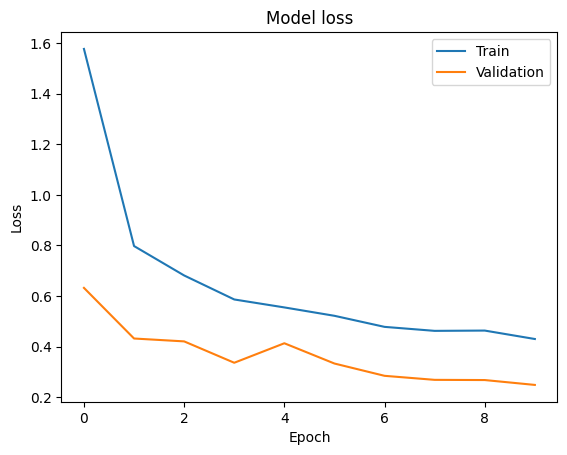

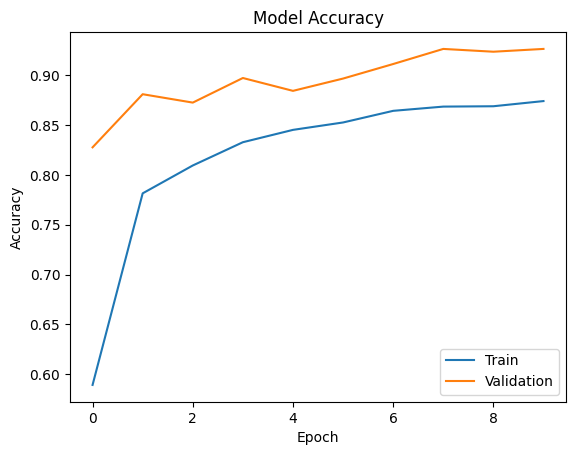

In [16]:
# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

56/56 - 52s - 937ms/step


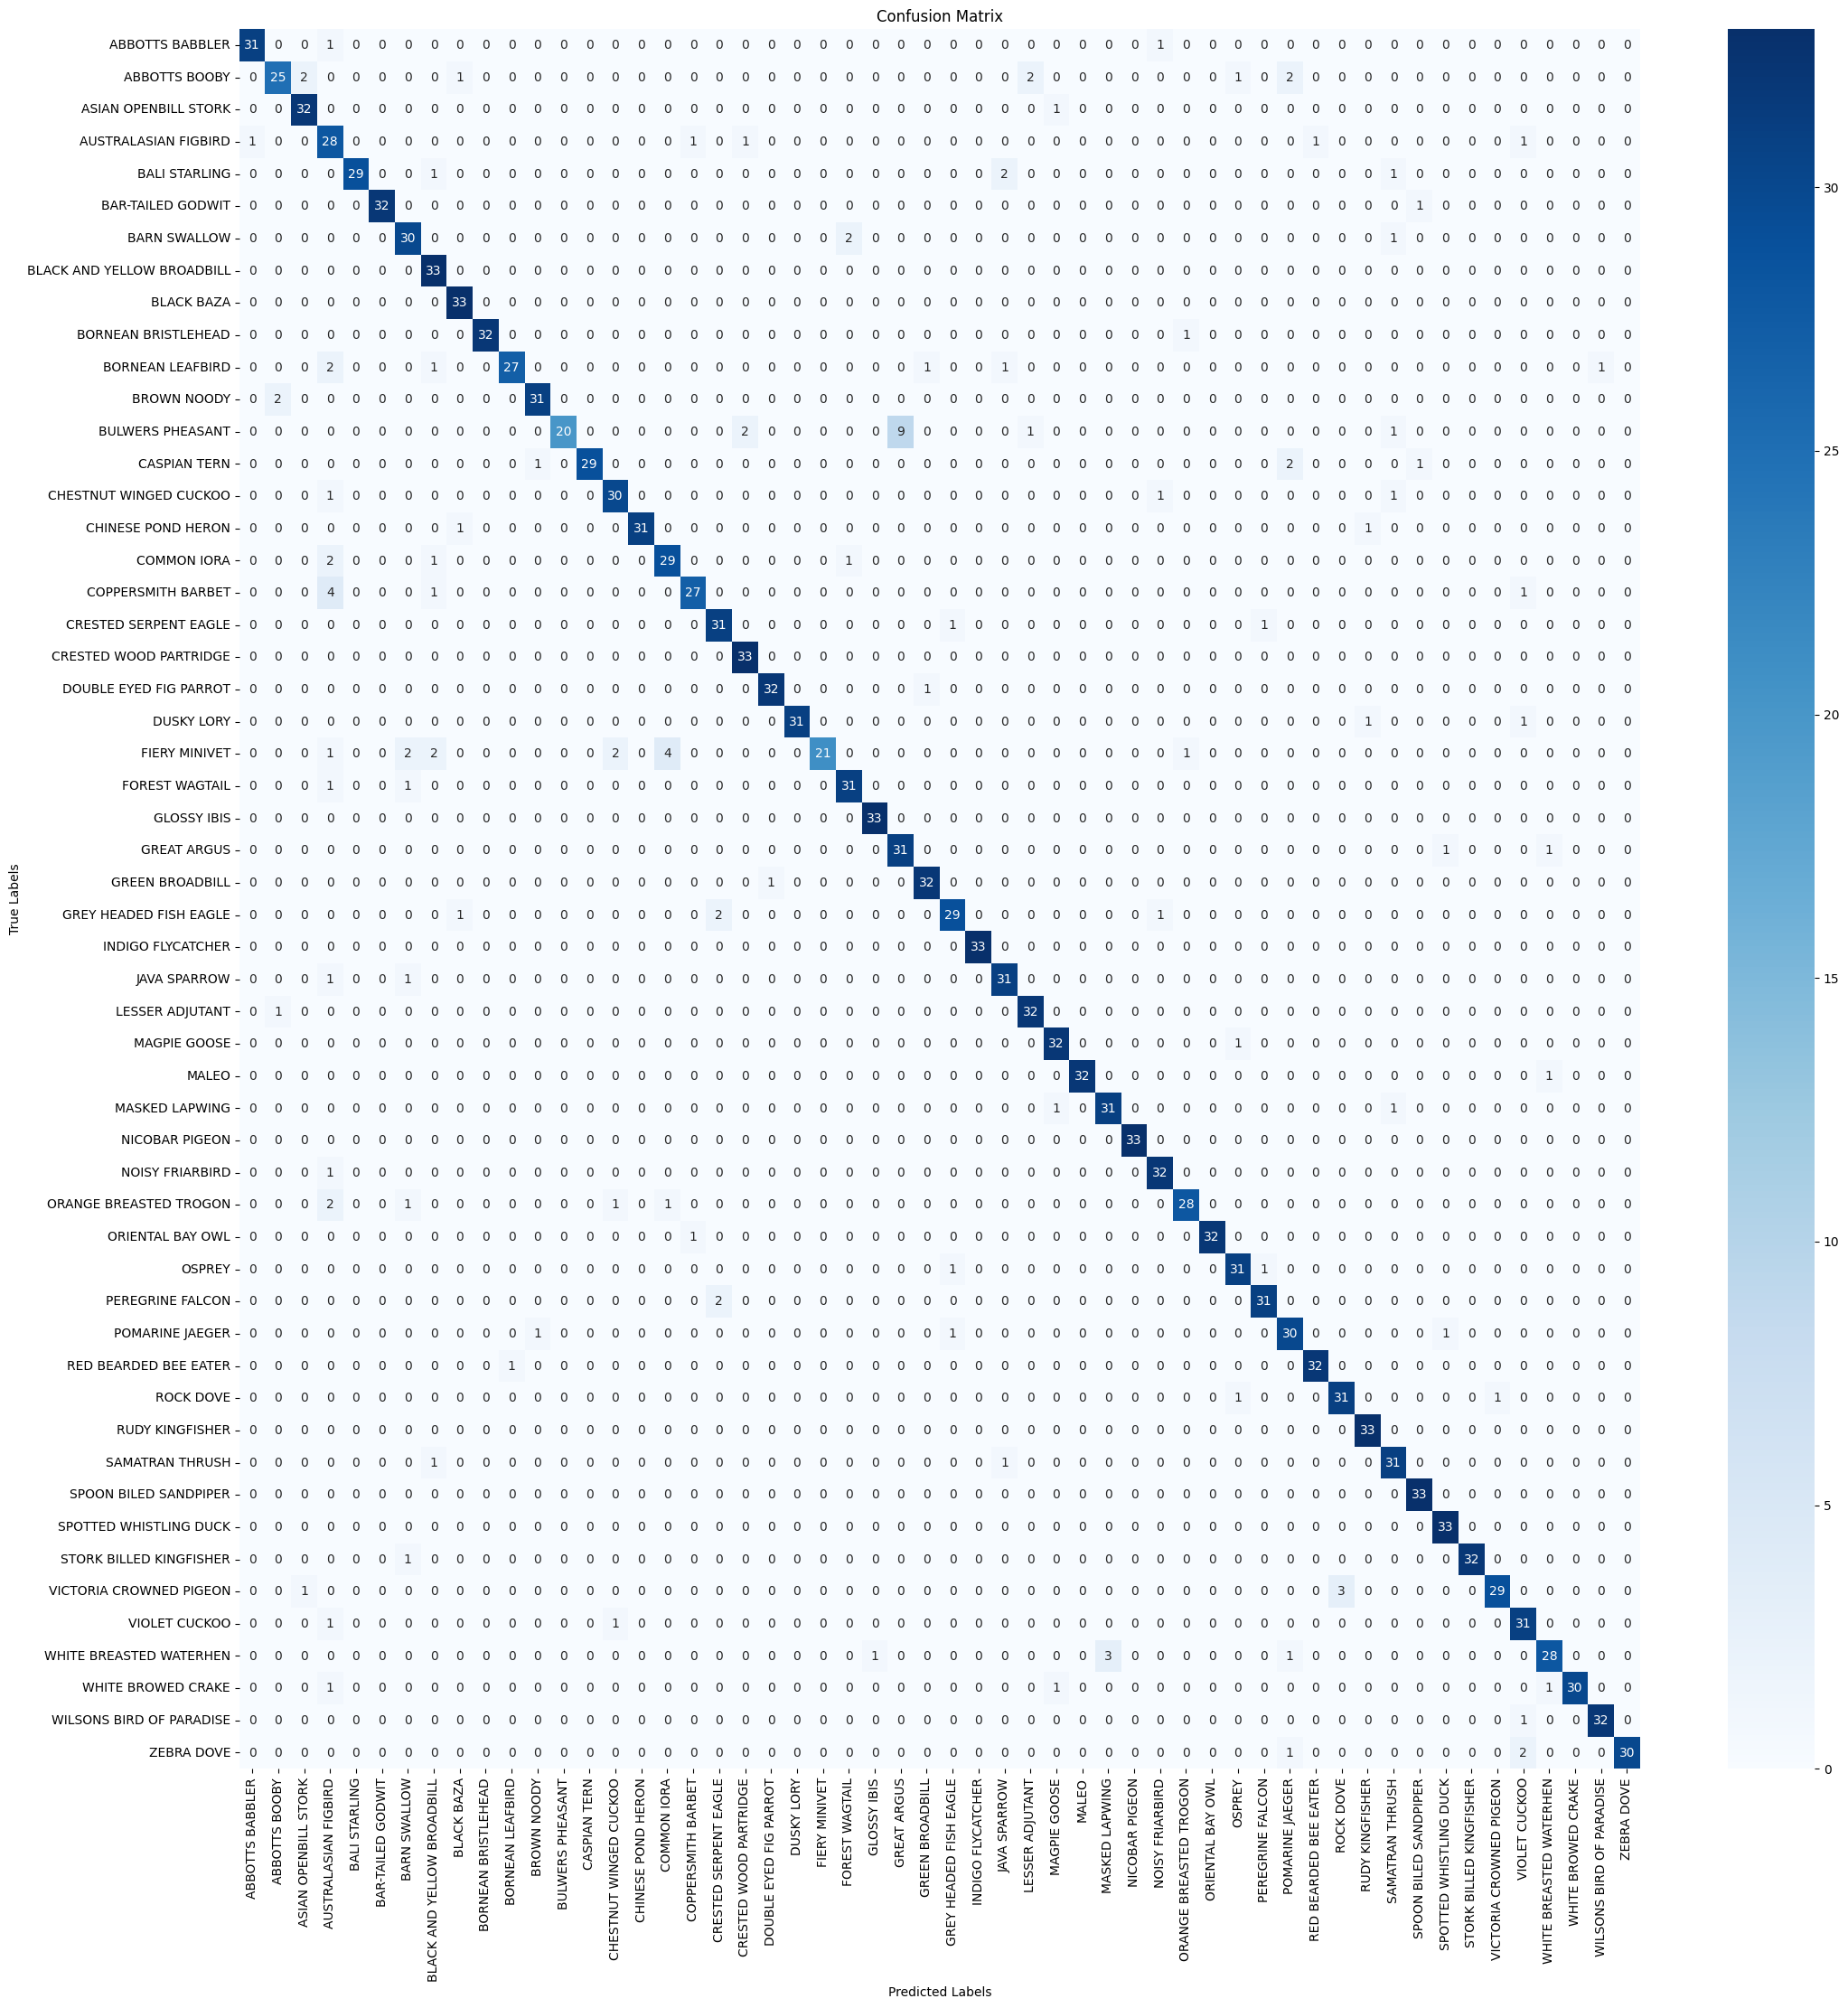

In [17]:
# Confusion matrix dan classification report
true_labels = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = model.predict(test_ds, verbose=2)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(true_labels, y_pred_labels)

plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
print('Classification Report:')
print(classification_report(true_labels, y_pred_labels, target_names=class_names))

Classification Report:
                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.97      0.94      0.95        33
             ABBOTTS BOOBY       0.89      0.76      0.82        33
      ASIAN OPENBILL STORK       0.91      0.97      0.94        33
      AUSTRALASIAN FIGBIRD       0.61      0.85      0.71        33
             BALI STARLING       1.00      0.88      0.94        33
         BAR-TAILED GODWIT       1.00      0.97      0.98        33
              BARN SWALLOW       0.83      0.91      0.87        33
BLACK AND YELLOW BROADBILL       0.82      1.00      0.90        33
                BLACK BAZA       0.92      1.00      0.96        33
       BORNEAN BRISTLEHEAD       1.00      0.97      0.98        33
          BORNEAN LEAFBIRD       0.96      0.82      0.89        33
               BROWN NOODY       0.94      0.94      0.94        33
          BULWERS PHEASANT       1.00      0.61      0.75        33
              CASPIAN TE

In [19]:
# Confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)
labels = class_names  # list nama kelas
results = []

# Inisialisasi untuk rata-rata
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
total_test_data = 0

# Hitung metrik per kelas
for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    total = TP + FN
    total_test_data += total

    # Hitung metrik
    accuracy = (TP + TN) / cm.sum() if cm.sum() > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Akumulasi untuk rata-rata
    total_precision += precision
    total_recall += recall
    total_f1 += f1_score

    results.append({
        'Class': label,
        'Total': total,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1_score, 4)
    })

# Hitung rata-rata
n_classes = len(labels)
avg_precision = total_precision / n_classes
avg_recall = total_recall / n_classes
avg_f1 = total_f1 / n_classes

# Tambahkan baris rata-rata ke DataFrame
results.append({
    'Class': 'Average',
    'Total': total_test_data,
    'TP': '-',
    'FP': '-',
    'FN': '-',
    'TN': '-',
    'Precision': round(avg_precision, 4),
    'Recall': round(avg_recall, 4),
    'F1-Score': round(avg_f1, 4)
})

# Buat DataFrame
metrics_df = pd.DataFrame(results)

metrics_df.to_excel('hasilmodel/cnn+inception/confusion_metrics_inceptionv4.xlsx', index=False)

In [20]:
# Confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)

# Inisialisasi list untuk hasil
labels = class_names
results = []

# Hitung TP, FP, FN, TN untuk setiap kelas
for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    results.append({
        'Class': label,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN
    })

# Buat dataframe
metrics_df = pd.DataFrame(results)

# Tampilkan tabel
print(metrics_df)

metrics_df.to_excel('hasilmodel/cnn+inception/tidaklengkapconfusion_metrics_inceptionv4.xlsx', index=False)

                         Class  TP  FP  FN    TN
0              ABBOTTS BABBLER  31   1   2  1748
1                ABBOTTS BOOBY  25   3   8  1746
2         ASIAN OPENBILL STORK  32   3   1  1746
3         AUSTRALASIAN FIGBIRD  28  18   5  1731
4                BALI STARLING  29   0   4  1749
5            BAR-TAILED GODWIT  32   0   1  1749
6                 BARN SWALLOW  30   6   3  1743
7   BLACK AND YELLOW BROADBILL  33   7   0  1742
8                   BLACK BAZA  33   3   0  1746
9          BORNEAN BRISTLEHEAD  32   0   1  1749
10            BORNEAN LEAFBIRD  27   1   6  1748
11                 BROWN NOODY  31   2   2  1747
12            BULWERS PHEASANT  20   0  13  1749
13                CASPIAN TERN  29   0   4  1749
14      CHESTNUT WINGED CUCKOO  30   4   3  1745
15          CHINESE POND HERON  31   0   2  1749
16                 COMMON IORA  29   5   4  1744
17          COPPERSMITH BARBET  27   2   6  1747
18       CRESTED SERPENT EAGLE  31   4   2  1745
19      CRESTED WOOD

In [21]:
model.save('hasilmodel/cnn+inception/inceptionv4.keras')

In [22]:
# Ambil nama folder dalam dataset/train sebagai label
class_names = sorted(os.listdir('dataset/train'))

# Simpan label ke dalam file labels.txt
with open('hasilmodel/cnn+inception/labelsinceptionv4.txt', 'w') as f:
    for label in class_names:
        f.write(f'{label}\n')

print('Label mapping saved to labelsinceptionv4.txt')

Label mapping saved to labelsinceptionv4.txt
